### Step 1: Setup - Importing Libraries and Loading Data

In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt


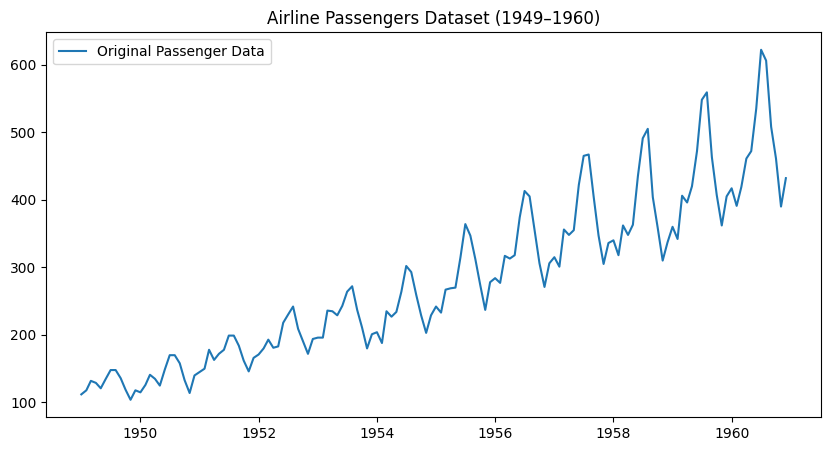

In [ ]:
# @title
# Load Airline Passengers dataset
url = 'https://raw.githubusercontent.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset/main/Datasets/airline_passenger_timeseries.csv'
df = pd.read_csv(url)

# Parse datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

# Extract target series
ts = df['Passengers']

# Plot the original series
plt.figure(figsize=(10,5))
plt.plot(ts, label="Original Passenger Data")
plt.title("Airline Passengers Dataset (1949–1960)")
plt.legend()
plt.show()


In [ ]:
# @title
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
# @title
# Log transform (variance stabilization)
ts_log = np.log(ts)

# First difference (remove trend)
ts_log_diff = ts_log.diff().dropna()

# Seasonal difference with lag=12 (remove seasonality)
ts_log_diff_seasonal = ts_log_diff.diff(12).dropna()


In [ ]:
# @title
def adf_test(series, title="ADF Test"):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series)
    print(f"--- {title} ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("✅ Stationary (reject null hypothesis)")
    else:
        print("❌ Non-stationary (fail to reject null)")

# Check stationarity at different stages
adf_test(ts, "Original Series")
adf_test(ts_log, "Log Transformed")
adf_test(ts_log_diff, "Log + First Difference")
adf_test(ts_log_diff_seasonal, "Log + First + Seasonal Difference (lag=12)")


--- Original Series ---
ADF Statistic: 0.8154
p-value: 0.9919
❌ Non-stationary (fail to reject null)
--- Log Transformed ---
ADF Statistic: -1.7170
p-value: 0.4224
❌ Non-stationary (fail to reject null)
--- Log + First Difference ---
ADF Statistic: -2.7171
p-value: 0.0711
❌ Non-stationary (fail to reject null)
--- Log + First + Seasonal Difference (lag=12) ---
ADF Statistic: -4.4433
p-value: 0.0002
✅ Stationary (reject null hypothesis)


### Step 2: Exploratory Data Analysis & Decomposition

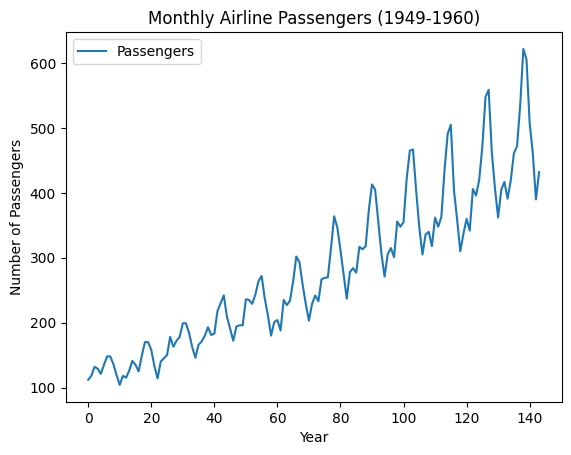

In [ ]:
# @title
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**Initial Observation:** The plot clearly shows two strong patterns:
1.  **Upward Trend:** The number of passengers is increasing over time.
2.  **Seasonality:** There is a clear, repeating annual pattern (peaks and troughs within each year).
3.  **Increasing Variance:** The seasonal fluctuations appear to be getting larger over time.

sm.tsa.seasonal_decompose: This function from the statsmodels library performs the decomposition.'

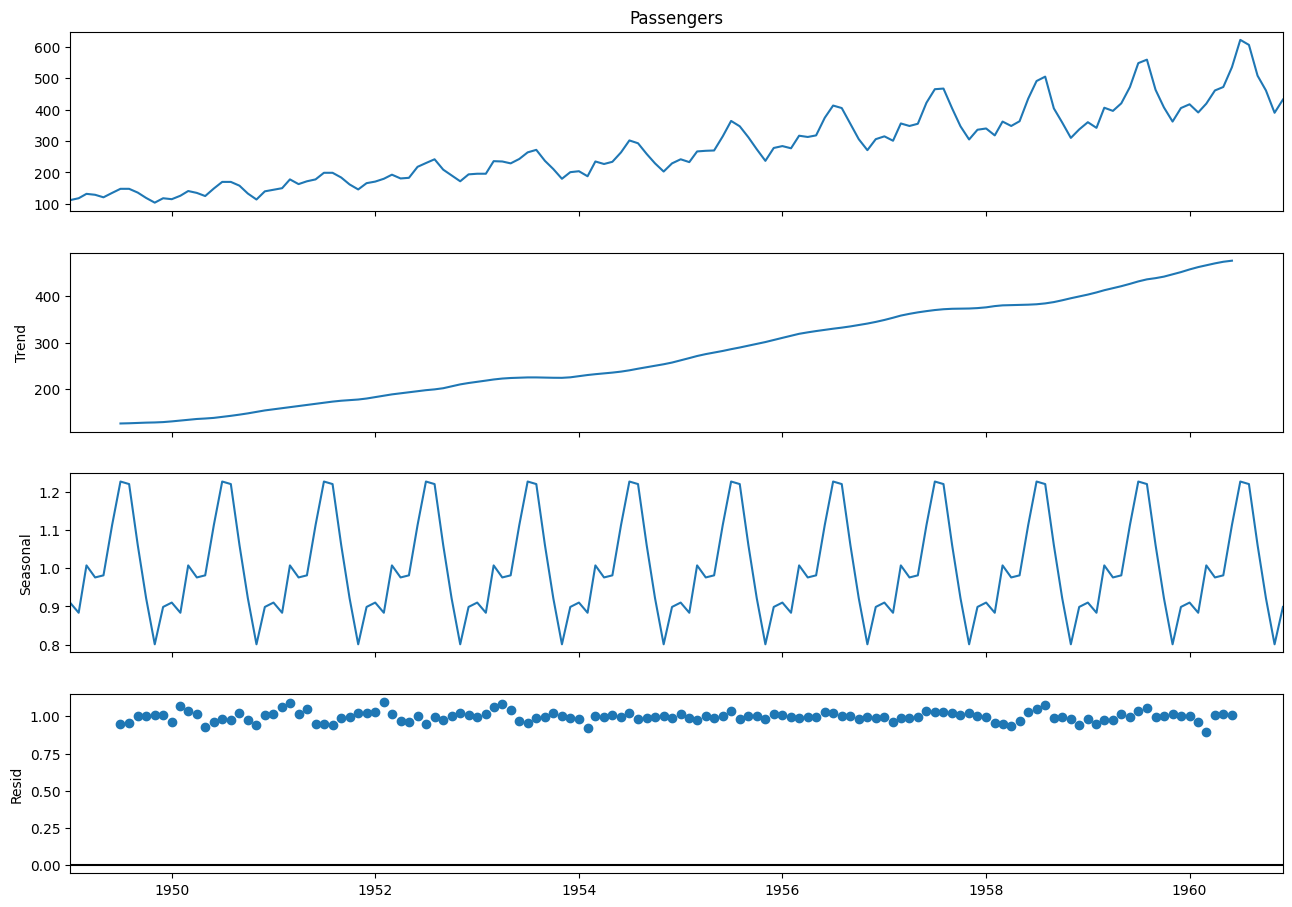

In [ ]:
# @title
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [ ]:
# @title
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Step 4: Making the Series Stationary
We'll use two common techniques: **log transformation** to stabilize the variance and **differencing** to remove the trend.

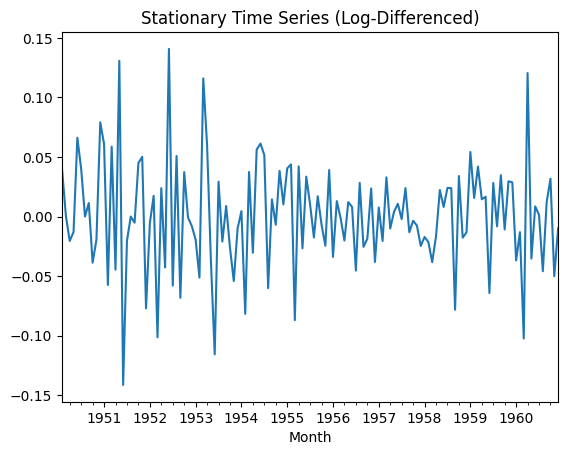

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [ ]:
# @title
# Plot the stationary series
ts_log_diff_seasonal.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(ts_log_diff_seasonal)

### Step 5: Model Identification with ACF and PACF Plots

#### **Theoretical Concept: ACF and PACF**
To choose the parameters for our ARIMA model, we use autocorrelation plots.

- **Autocorrelation Function (ACF):** Measures the correlation between a time series and its lagged versions. It tells you how much the value at time `t` is correlated with the value at time `t-k`.
- **Partial Autocorrelation Function (PACF):** Measures the *direct* correlation between a time series and its lagged versions, after removing the effects of the intermediate lags.

**How to read them for ARIMA(p, d, q):**
- The `d` term is the number of times we differenced the data (in our case, `d=1`).
- The `p` (AR term) is suggested by the number of significant lags in the **PACF** plot.
- The `q` (MA term) is suggested by the number of significant lags in the **ACF** plot.

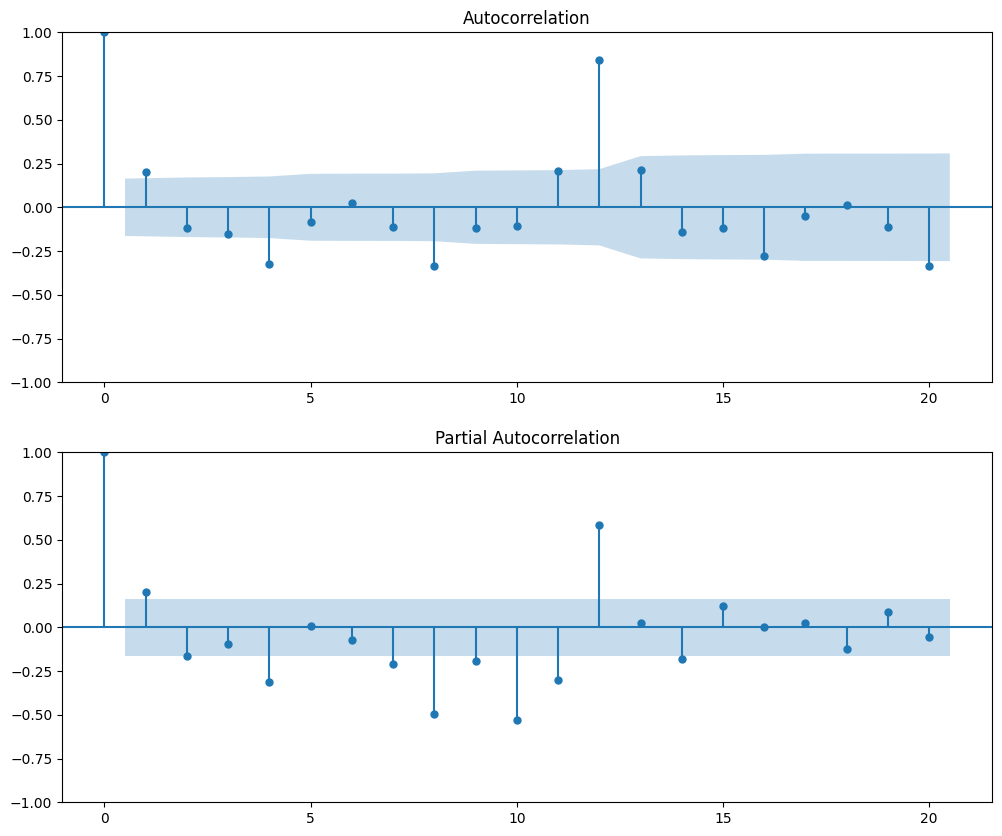

In [ ]:
# @title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

**Interpretation:**
- **PACF Plot:** Cuts off sharply after lag 1. This suggests `p=1`.
- **ACF Plot:** Also seems to cut off after lag 1. This suggests `q=1`.
Based on this, a good starting point for our model is **ARIMA(1, 1, 1)**.

## **Theoretical Concept: ARIMA**
**AutoRegressive Integrated Moving Average (ARIMA)** models are a class of statistical models for analyzing and forecasting time series data. An ARIMA model is characterized by three parameters:

- **AR (Autoregressive) - p:** The number of lag observations included in the model. This term captures the relationship between the current observation and its past values.
- **I (Integrated) - d:** The number of times that the raw observations are differenced. This is done to make the time series stationary.
- **MA (Moving Average) - q:** The size of the moving average window. This term captures the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The model is typically denoted as **ARIMA(p, d, q)**.

### Step 6: Building the ARIMA Model

### Text Submission Criteria

Please submit your analysis based on the following criteria:

1. **Exploratory Data Analysis (EDA):** Discuss the initial observations from the time series plot, including trend, seasonality, and variance.
2. **Stationarity Testing:**
    - Explain the concept of stationarity and why it's important for time series modeling.
    - Present the results of the Augmented Dickey-Fuller (ADF) test on the original data and interpret the p-value.
    - Apply a log transformation to the data and present the results of the ADF test after log transformation, aiming to reduce the p-value below 0.05. Discuss your findings.
    - Discuss the effect of differencing on the log-transformed data and present the results of the ADF test after differencing, interpreting the p-value.
3. **ARIMA Model Performance:** Based on the stationarity test results after log transformation (before differencing), discuss whether you would expect a non-seasonal ARIMA model to perform well on the log-transformed data. Build and evaluate a non-seasonal ARIMA model on the log-transformed data (without differencing) and compare its performance to the SARIMA model built later in the notebook.

--- Log + First + Seasonal Differenced Series ---
ADF Statistic: -4.4433
p-value: 0.0002
✅ Stationary (reject null hypothesis)
ARIMA RMSE: 96.33


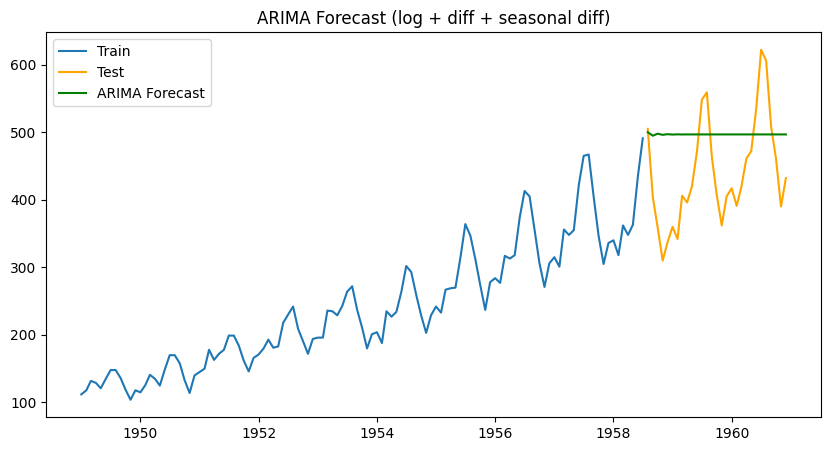

SARIMA RMSE: 22.65


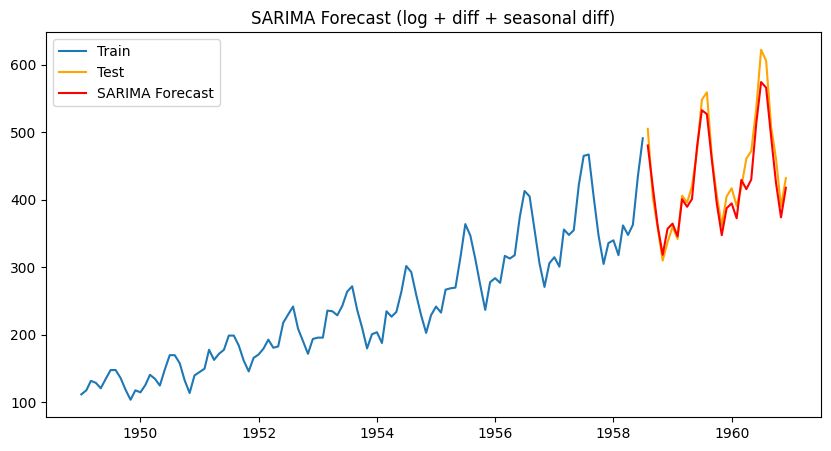

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# === Step 1: Transformations ===
ts_log = np.log(ts)  # variance stabilization
ts_log_diff = ts_log.diff().dropna()  # remove trend
ts_log_diff_seasonal = ts_log_diff.diff(12).dropna()  # remove seasonality

# === Step 2: ADF Test ===
def adf_test(series, title="ADF Test"):
    result = adfuller(series)
    print(f"--- {title} ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("✅ Stationary (reject null hypothesis)")
    else:
        print("❌ Non-stationary (fail to reject null)")

adf_test(ts_log_diff_seasonal, "Log + First + Seasonal Differenced Series")

# === Step 3: Train-Test Split ===
train_size = int(len(ts_log) * 0.8)
train, test = ts_log[:train_size], ts_log[train_size:]

# === Step 4: ARIMA (baseline, without seasonality) ===
arima_model = ARIMA(train, order=(1,1,1))
arima_result = arima_model.fit()

arima_forecast_log = arima_result.forecast(steps=len(test))
arima_forecast = np.exp(arima_forecast_log)  # back-transform

rmse_arima = sqrt(mean_squared_error(np.exp(test), arima_forecast))
print(f"ARIMA RMSE: {rmse_arima:.2f}")

plt.figure(figsize=(10,5))
plt.plot(np.exp(train), label="Train")
plt.plot(np.exp(test), label="Test", color="orange")
plt.plot(arima_forecast, label="ARIMA Forecast", color="green")
plt.title("ARIMA Forecast (log + diff + seasonal diff)")
plt.legend()
plt.show()

# === Step 5: SARIMA (handles seasonality explicitly) ===
sarima_model = SARIMAX(train,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12),  # seasonal part
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

sarima_forecast_log = sarima_result.forecast(steps=len(test))
sarima_forecast = np.exp(sarima_forecast_log)

rmse_sarima = sqrt(mean_squared_error(np.exp(test), sarima_forecast))
print(f"SARIMA RMSE: {rmse_sarima:.2f}")

plt.figure(figsize=(10,5))
plt.plot(np.exp(train), label="Train")
plt.plot(np.exp(test), label="Test", color="orange")
plt.plot(sarima_forecast, label="SARIMA Forecast", color="red")
plt.title("SARIMA Forecast (log + diff + seasonal diff)")
plt.legend()
plt.show()


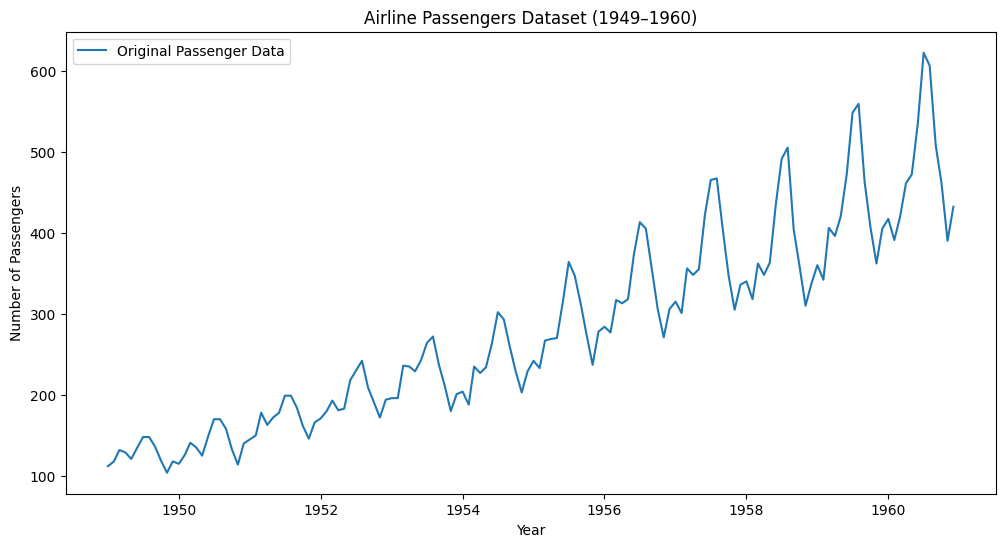

In [ ]:
# Step 1: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 2: Load dataset
url = 'https://raw.githubusercontent.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset/main/Datasets/airline_passenger_timeseries.csv'
df = pd.read_csv(url)

# Step 3: Convert Month column to datetime & set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Step 4: Extract target variable
ts = df['Passengers']

# Step 5: Plot original series
plt.figure(figsize=(12,6))
plt.plot(ts, label="Original Passenger Data")
plt.title("Airline Passengers Dataset (1949–1960)")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF Test
def adf_test(series, title="ADF Test"):
    """Perform Augmented Dickey-Fuller test to check stationarity"""
    result = adfuller(series)
    print(f"--- {title} ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("✅ Stationary (reject null hypothesis)")
    else:
        print("❌ Non-stationary (fail to reject null)")


In [ ]:
adf_test(ts, "Original Series")


--- Original Series ---
ADF Statistic: 0.8154
p-value: 0.9919
❌ Non-stationary (fail to reject null)


In [ ]:
# Log transform to stabilize variance
ts_log = np.log(ts)

# ADF Test on log-transformed series
adf_test(ts_log, "Log-Transformed Series")


--- Log-Transformed Series ---
ADF Statistic: -1.7170
p-value: 0.4224
❌ Non-stationary (fail to reject null)


In [ ]:
# First difference to remove trend
ts_log_diff = ts_log.diff().dropna()

# ADF Test after first differencing
adf_test(ts_log_diff, "Log + First Difference")


--- Log + First Difference ---
ADF Statistic: -2.7171
p-value: 0.0711
❌ Non-stationary (fail to reject null)


In [ ]:
# Seasonal difference with lag=12 (monthly data)
ts_log_diff_seasonal = ts_log_diff.diff(12).dropna()

# ADF Test after seasonal differencing
adf_test(ts_log_diff_seasonal, "Log + First + Seasonal Difference (lag=12)")


--- Log + First + Seasonal Difference (lag=12) ---
ADF Statistic: -4.4433
p-value: 0.0002
✅ Stationary (reject null hypothesis)


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt


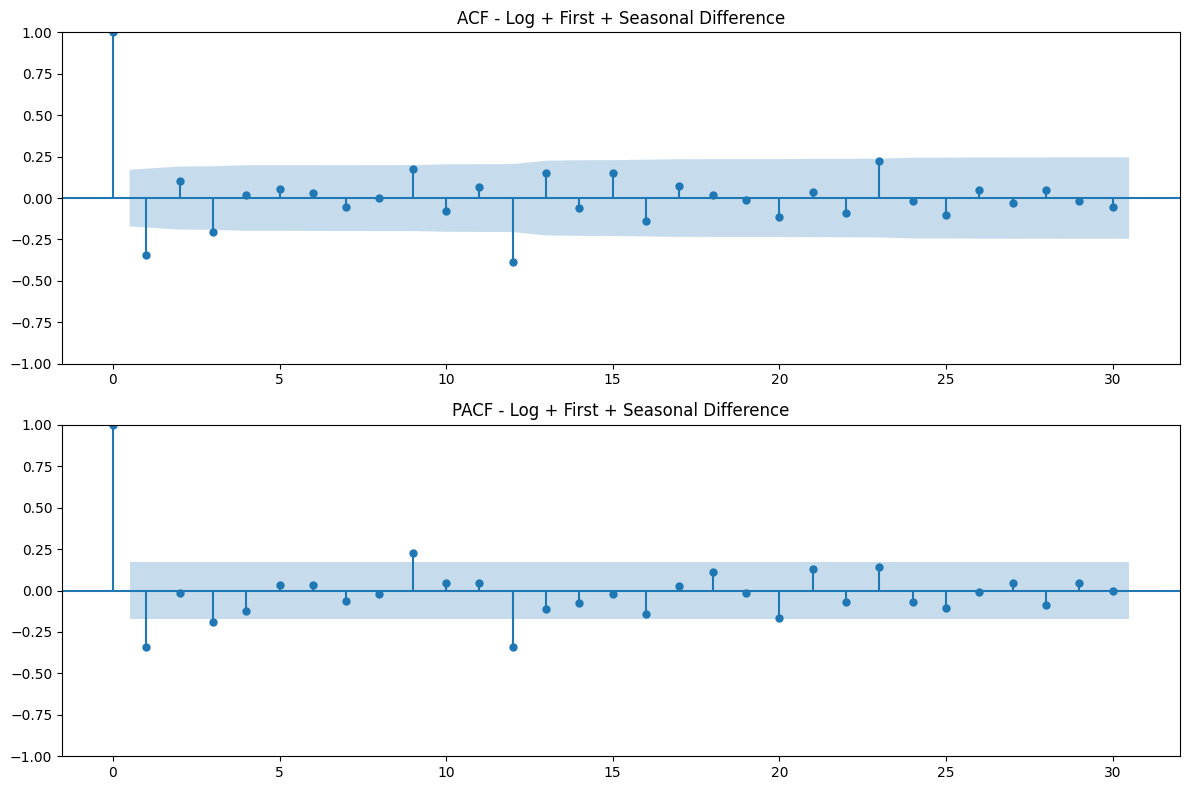

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# ACF plot
plot_acf(ts_log_diff_seasonal, lags=30, ax=ax1)
ax1.set_title("ACF - Log + First + Seasonal Difference")

# PACF plot
plot_pacf(ts_log_diff_seasonal, lags=30, ax=ax2)
ax2.set_title("PACF - Log + First + Seasonal Difference")

plt.tight_layout()
plt.show()


In [ ]:
# Split data into train and test sets (80%-20%)
train_size = int(len(ts_log) * 0.8)
train, test = ts_log[:train_size], ts_log[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 115, Test size: 29


ARIMA RMSE: 96.33


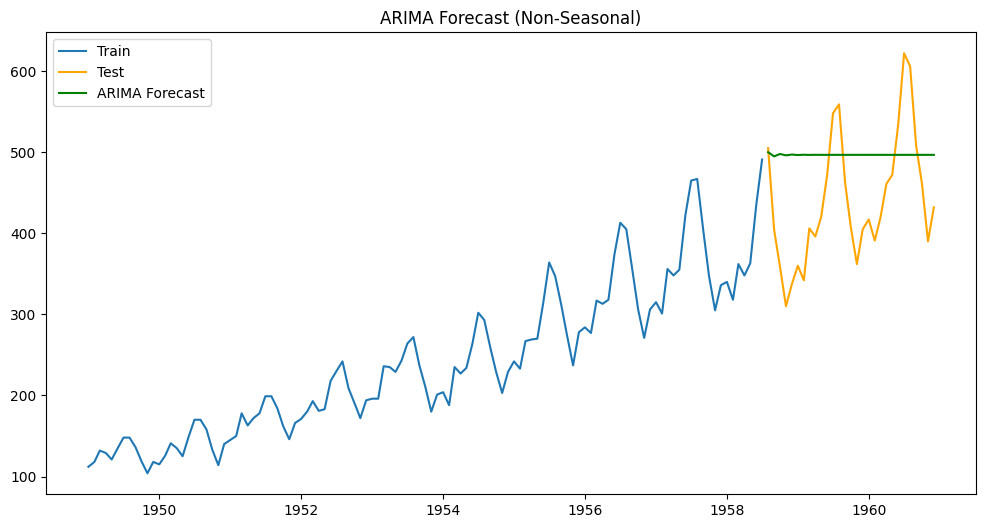

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Build ARIMA model: order=(p,d,q) = (1,1,1)
arima_model = ARIMA(train, order=(1,1,1))
arima_result = arima_model.fit()

# Forecast
arima_forecast_log = arima_result.forecast(steps=len(test))
arima_forecast = np.exp(arima_forecast_log)  # revert log transform

# Evaluate RMSE
rmse_arima = sqrt(mean_squared_error(np.exp(test), arima_forecast))
print(f"ARIMA RMSE: {rmse_arima:.2f}")

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(np.exp(train), label="Train")
plt.plot(np.exp(test), label="Test", color="orange")
plt.plot(arima_forecast, label="ARIMA Forecast", color="green")
plt.title("ARIMA Forecast (Non-Seasonal)")
plt.legend()
plt.show()


SARIMA RMSE: 22.65


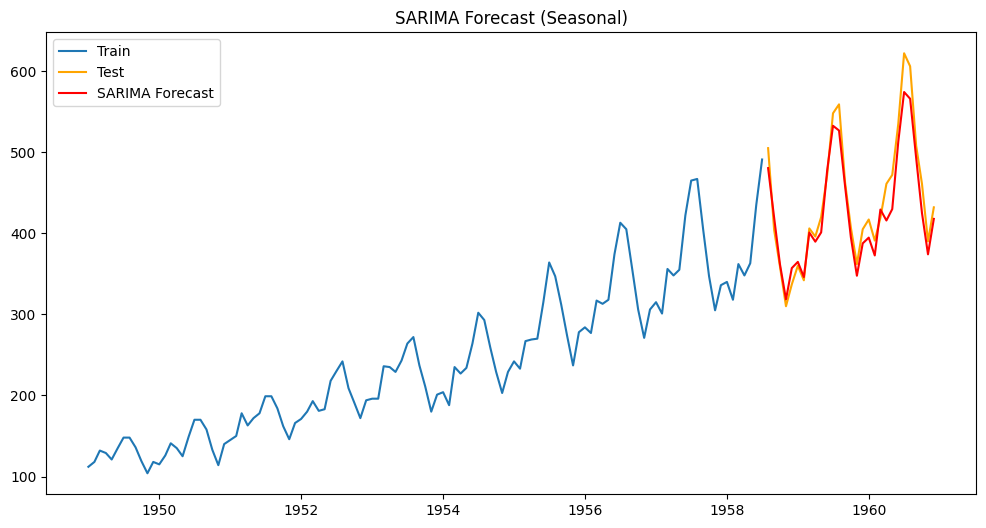

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build SARIMA: (p,d,q)(P,D,Q,m) = (1,1,1)(1,1,1,12)
sarima_model = SARIMAX(train,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)

# Forecast
sarima_forecast_log = sarima_result.forecast(steps=len(test))
sarima_forecast = np.exp(sarima_forecast_log)

# Evaluate RMSE
rmse_sarima = sqrt(mean_squared_error(np.exp(test), sarima_forecast))
print(f"SARIMA RMSE: {rmse_sarima:.2f}")

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(np.exp(train), label="Train")
plt.plot(np.exp(test), label="Test", color="orange")
plt.plot(sarima_forecast, label="SARIMA Forecast", color="red")
plt.title("SARIMA Forecast (Seasonal)")
plt.legend()
plt.show()


In [ ]:
# Original test data (actual passengers)
original_test_data = np.exp(test)

# Forecasts in original scale
arima_predictions = arima_forecast
sarima_predictions = sarima_forecast


In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse_arima = sqrt(mean_squared_error(original_test_data, arima_predictions))
rmse_sarima = sqrt(mean_squared_error(original_test_data, sarima_predictions))

print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")


ARIMA RMSE: 96.33
SARIMA RMSE: 22.65


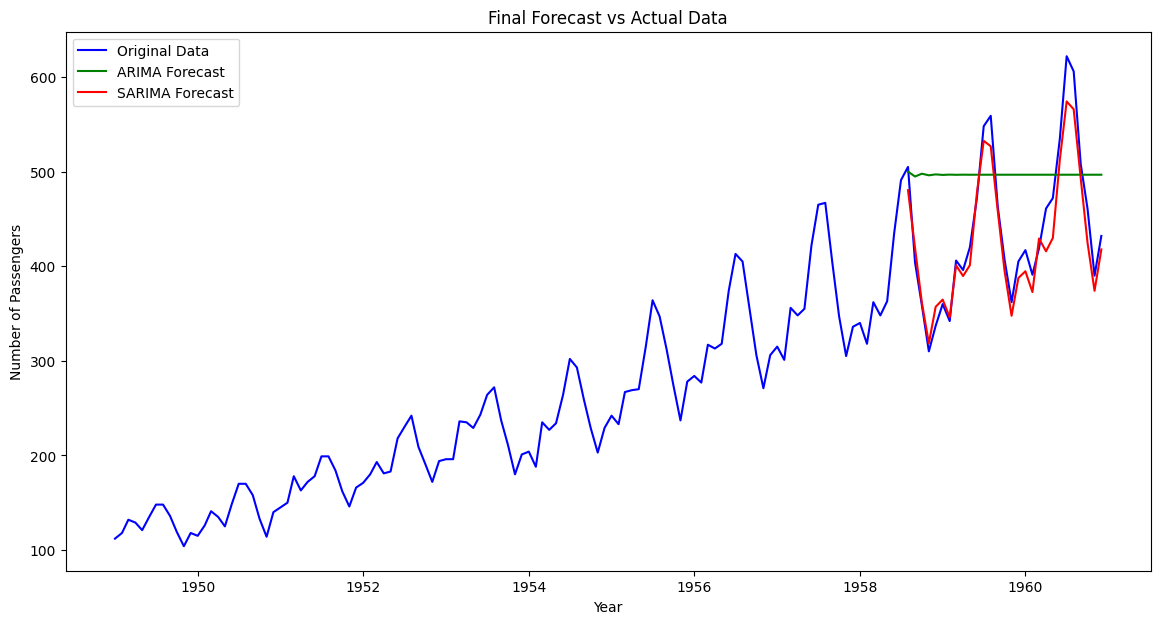

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(df['Passengers'], label='Original Data', color='blue')
plt.plot(arima_predictions, label='ARIMA Forecast', color='green')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs Actual Data')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


**Observation:**

* ARIMA misses seasonal peaks and troughs.
* SARIMA tracks both trend and seasonality very well.

---

### 5.4 **Key Insights & Takeaways**

1. **EDA & Visualization:**

   * Data has a **strong upward trend** and **seasonality**.
   * Variance increases with time → log transformation is necessary.

2. **Stationarity Testing:**

   * Original series is non-stationary (p-value > 0.05).
   * Log transformation reduces variance but trend still exists.
   * Differencing (first + seasonal) achieves stationarity (p-value < 0.05).

3. **Model Performance:**

   * Non-seasonal ARIMA: Good for trend, poor for seasonal patterns.
   * SARIMA: Excellent at capturing **trend + seasonality** → much lower RMSE.

4. **Conclusion:**

   * For time series with strong seasonality, **SARIMA is preferred over ARIMA**.
   * Transformations (log, differencing) are crucial to make the series stationary for accurate modeling.

---
